# Assignment 5


*Please fill out the relevant cells below according to the instructions. When done, save the notebook and export it to PDF, upload both the `ipynb` and the PDF file to Canvas.*

## Group Members

*Group submission is highly encouraged. If you submit as part of group, list all group members here. Groups can comprise up to 4 students.*

* Declan Campbell
* Vanessa Roser

---

## Problem 1: Automatic Hubble (3pts)

Go back to Assignment 3. Get the Hubble data and take the GP error model from Problem 1.3 to solve the linear regression with correlated errors, but this time use `emcee` to get the posteriors.

Adopt non-informative priors, i.e. $p(b) \propto (1+b^2)^{-3/2}$ and $p(\sigma_y)\propto 1/\sigma_y$, and whatever you feel is appropriate for the priors of the parameter $\alpha$ and $\tau$ of the Matern kernel.

Plot the parameter contours with `corner` and make another plot that compares the data with samples of the posterior.

In [ ]:
hubble = np.loadtxt('data.txt')

## Problem 2: HMC for Hierarchical Regression (7pts)

Implement the hierarchical linear regression model for math scores vs socio-econonic status (SES) from 100 schools we discussed in the lecture. But instead of the complicated Gibbs sampling sequence with its full conditionals, compute posteriors with HMC/NUTS.

## Problem 2.1 (3pts):

Get the data from the Hoff 2009 book [here](https://github.com/probml/pmtk3/blob/master/data/mathDataHoff.csv).
Treat each school independently and perform linear regression (with an unknown error) of math score as function of SES. Specifically, implement this model in `numpyro`:

\begin{align}
\mu &\sim \mathcal{N}(\mu_0, V_0)\\
\Sigma &\sim \mathrm{IW} (\eta_0, S_0^{-1})\\
w_j&\sim\mathcal{N}(\mu,\Sigma)\\
\sigma^2 &\sim \mathrm{IG} (\tfrac{1}{2}\nu_0, \tfrac{1}{2}\nu_0 \sigma_0^2)\\
e_{ij}&\sim\mathcal{N}(0, \sigma^2)
\end{align}

Take the mean of the posterior samples for the per-school linear regression weights and make a plot of these mean posterior predictions (see panel a) of Murphy Fig. 24.4). Store the posterior means of $w_j$ and $\sigma_j$ for every school for Problem 2.3.

**Hints**: 

* Pick reasonable values for the hyper-parameters $\mu_0, V_0,\dots$. A good method is to plot the resulting parameter distributions and compare them to the data. They should be wide enough to not overly influence the inference.
* The inverse Wishart distribution is not available in NumPyro yet. For univariate cases, it is identical to the inverse Gamma distribution. For the $2\times 2$ covariance $\Sigma$, assume independence of the slope and the intercept variances. Thus, sample two independent RVs from the inverse Gamma and treat them like a diagonal matrix covariance matrix. 
* ```
import jax.numpy as np
import numpy as onp
```

In [79]:
import numpyro
import pandas as pd
import numpyro.distributions as dist
import jax.numpy as np
from jax import random, lax
import matplotlib.pyplot as plt

# Define the hierarchical linear regression model
def hierarchical_linear_regression(ses, math, sch_id, n_schools=100):
    # Priors
    mu = numpyro.sample('mu', dist.Normal(0, 10))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    w_mu = numpyro.sample('w_mu', dist.Normal(0, 10))
    sigma_intercept = numpyro.sample('sigma_intercept', dist.HalfCauchy(5))
    sigma_slope = numpyro.sample('sigma_slope', dist.HalfCauchy(5))
    # School-level parameters
    with numpyro.plate('schools', n_schools):
        w = numpyro.sample('w', dist.MultivariateNormal(np.array([w_mu, mu]), np.diag(np.array([sigma_intercept ** 2, sigma_slope ** 2]))))
    # Likelihood
    with numpyro.plate('data', len(math)):
        intercept = w[sch_id-1, 0] # Index into w using sch_id
        slope = w[sch_id-1, 1]     # Index into w using sch_id
        sigma = numpyro.sample('sigma', dist.HalfCauchy(tau))
        mu = intercept + slope * ses
        numpyro.sample('math', dist.Normal(mu, sigma), obs=math)
    return w, sigma

# Run inference using HMC/NUTS.
def run_inference(data):
    kernel = numpyro.infer.NUTS(hierarchical_linear_regression)
    mcmc = numpyro.infer.MCMC(kernel, num_warmup=1000, num_samples=5000, num_chains=1)
    n_schools = len(np.unique(data['sch_id'].values))
    mcmc.run(random.PRNGKey(0), data['stu_ses'].values, data['stu_mathscore'].values, data['sch_id'].values)
    samples = mcmc.get_samples()
    return samples

# Run the model and get the posterior means for w and sigma for each school
data = pd.read_csv('mathDataHoff.csv')
data.sch_id = np.unique(data.sch_id.values,return_inverse=True)[1] # Make the school ID's neater
samples = run_inference(data)
w_mean = np.mean(samples['w'], axis=0)
sigma_mean = np.mean(samples['sigma'], axis=0)

sample: 100%|███████████████████████████████████████████████████████| 6000/6000 [08:31<00:00, 11.73it/s, 1023 steps of size 4.02e-03. acc. prob=0.79]


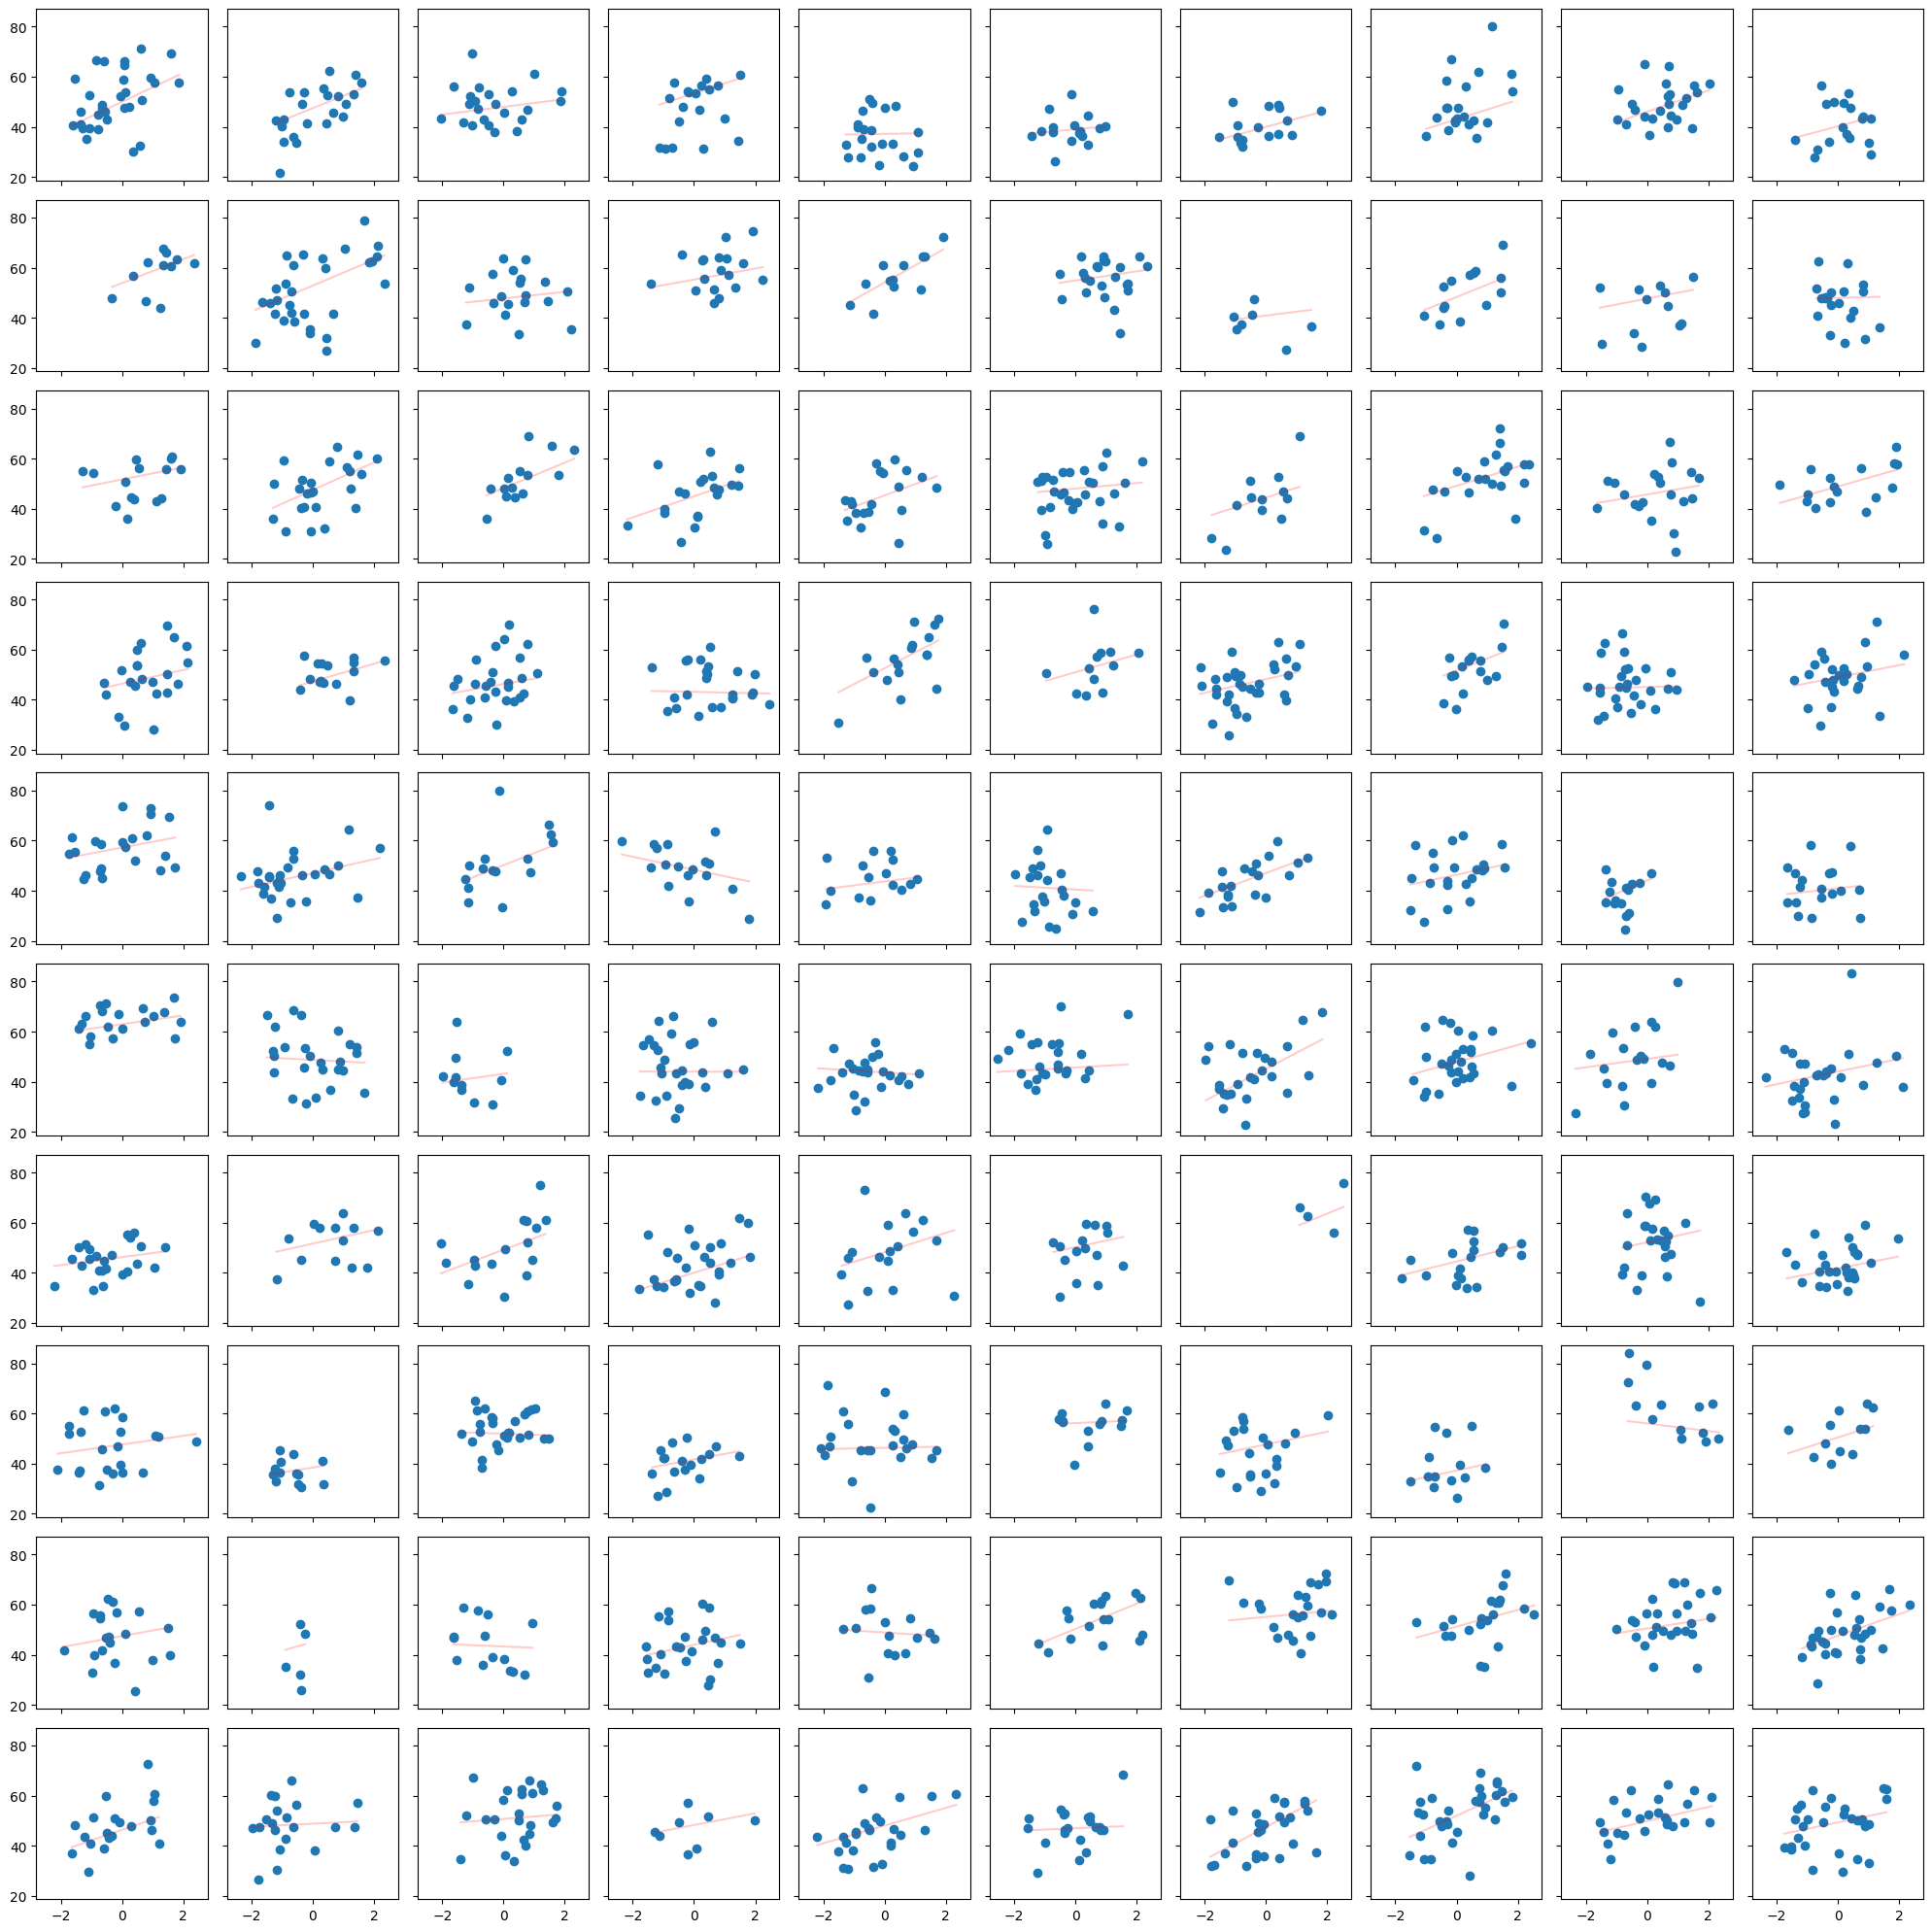

In [80]:
fig, axes = plt.subplots(10, 10, sharex=True, sharey=True, tight_layout=True, figsize=(20,20))

for ax, school_id in zip(axes.ravel(), data['sch_id'].unique()):
    school_data = data[data['sch_id'] == school_id]
    ses_range = np.linspace(school_data['stu_ses'].min(), school_data['stu_ses'].max(), 100)
    intercept_mean = w_mean[school_id-1, 0]
    slope_mean = w_mean[school_id-1, 1]
    mathscore_mean = intercept_mean + slope_mean * ses_range
    ax.plot(ses_range, mathscore_mean, alpha=0.2, color='red')
    ax.scatter(school_data['stu_ses'], school_data['stu_mathscore'])

### Problem 2.2 (3pts):

Now implement the full hierarchical scheme for the school regression coefficient $w_j$ we introduced in the lecture. Use the same hyperprior parameterization you used in 2.1. In other words, the only thing that changes is the linear model now predicts the values for the entire data set. 

Make a corner plot of the posterior for the set of hyperparameters $(\mu, \Sigma, \sigma)$. In another plot, show the linear regression from the mean posterior prediction for every school. Store the posterior means of $w_j$ for every school and of the global $\sigma$ for Problem 2.3.

**Hint:** `numpyro.plate` could be useful. 

In [63]:
import numpyro
import pandas as pd
import numpyro.distributions as dist
import jax.numpy as np
from jax import random, lax
import matplotlib.pyplot as plt
import corner

# Define the hierarchical linear regression model with full hierarchy
def hierarchical_linear_regression_full(ses, math, sch_id, n_schools=100):
    # Priors
    mu = numpyro.sample('mu', dist.Normal(0, 10))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    sigma_intercept = numpyro.sample('sigma_intercept', dist.HalfCauchy(5))
    sigma_slope = numpyro.sample('sigma_slope', dist.HalfCauchy(5))
    # Global parameters
    w = numpyro.sample('w', dist.Normal(mu, sigma_slope), sample_shape=(n_schools,))
    sigma = numpyro.sample('sigma', dist.HalfCauchy(tau))
    # Likelihood
    with numpyro.plate('data', len(math)):
        intercept = w[sch_id-1] # Index into w using sch_id
        mu = intercept + ses * np.broadcast_to(mu, ses.shape) # Broadcast mu to match ses shape
        numpyro.sample('math', dist.Normal(mu, sigma), obs=math)
    return w, sigma

# Run inference using HMC/NUTS.
def run_inference(data):
    kernel = numpyro.infer.NUTS(hierarchical_linear_regression_full)
    mcmc = numpyro.infer.MCMC(kernel, num_warmup=1000, num_samples=5000, num_chains=1)
    n_schools = len(np.unique(data['sch_id'].values))
    mcmc.run(random.PRNGKey(0), data['stu_ses'].values, data['stu_mathscore'].values, data['sch_id'].values, n_schools=n_schools)
    samples = mcmc.get_samples()
    return samples

# Run the model and get the posterior means for w and sigma for each school
data = pd.read_csv('mathDataHoff.csv')
data.sch_id = np.unique(data.sch_id.values,return_inverse=True)[1] # Make the school ID's neater
samples = run_inference(data)
w_mean = np.mean(samples['w'], axis=0)
sigma_mean = np.mean(samples['sigma'], axis=0)

sample: 100%|████████████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1046.91it/s, 7 steps of size 4.27e-01. acc. prob=0.86]


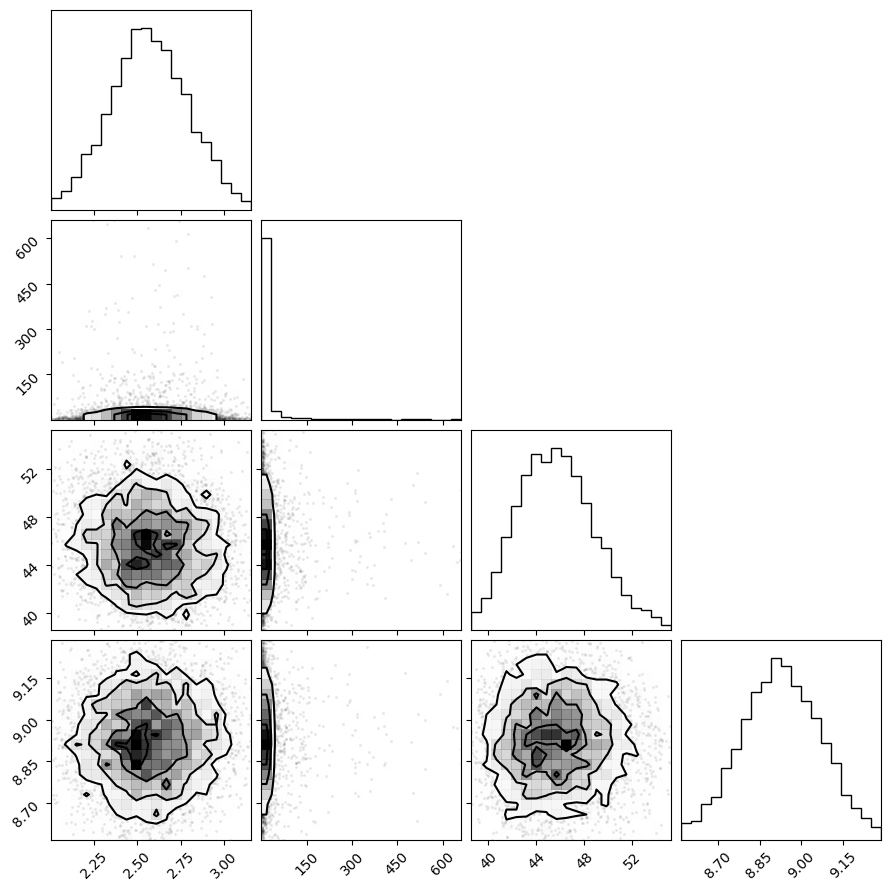

In [77]:
import numpy as np

# Plot the posterior distribution of hyperparameters
corner_data = np.column_stack((samples['mu'], samples['sigma_intercept'], samples['sigma_slope'], samples['sigma']))
corner_labels = [r'$\mu$', r'$\sigma_{\text{intercept}}$', r'$\sigma_{\text{slope}}$', r'$\sigma$']
corner_data = np.array(corner_data)
rngs = [0.99, 0.99, 0.99, 0.99]
figure = corner.corner(corner_data, range=rngs)

### Problem 2.3 (1pt):

Make a [quiver plot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.quiver.html) with the coordinates $(w_{j,0}, \sigma_j)$ from 2.1 as starting points and $(w_{j,0},\sigma)$ from 2.2 as end points (one arrow per school). Do the same with $w_{j,1}$ instead of $w_{j,0}$. Color-code each arrow with the number of students in each school. Interpret the result. 

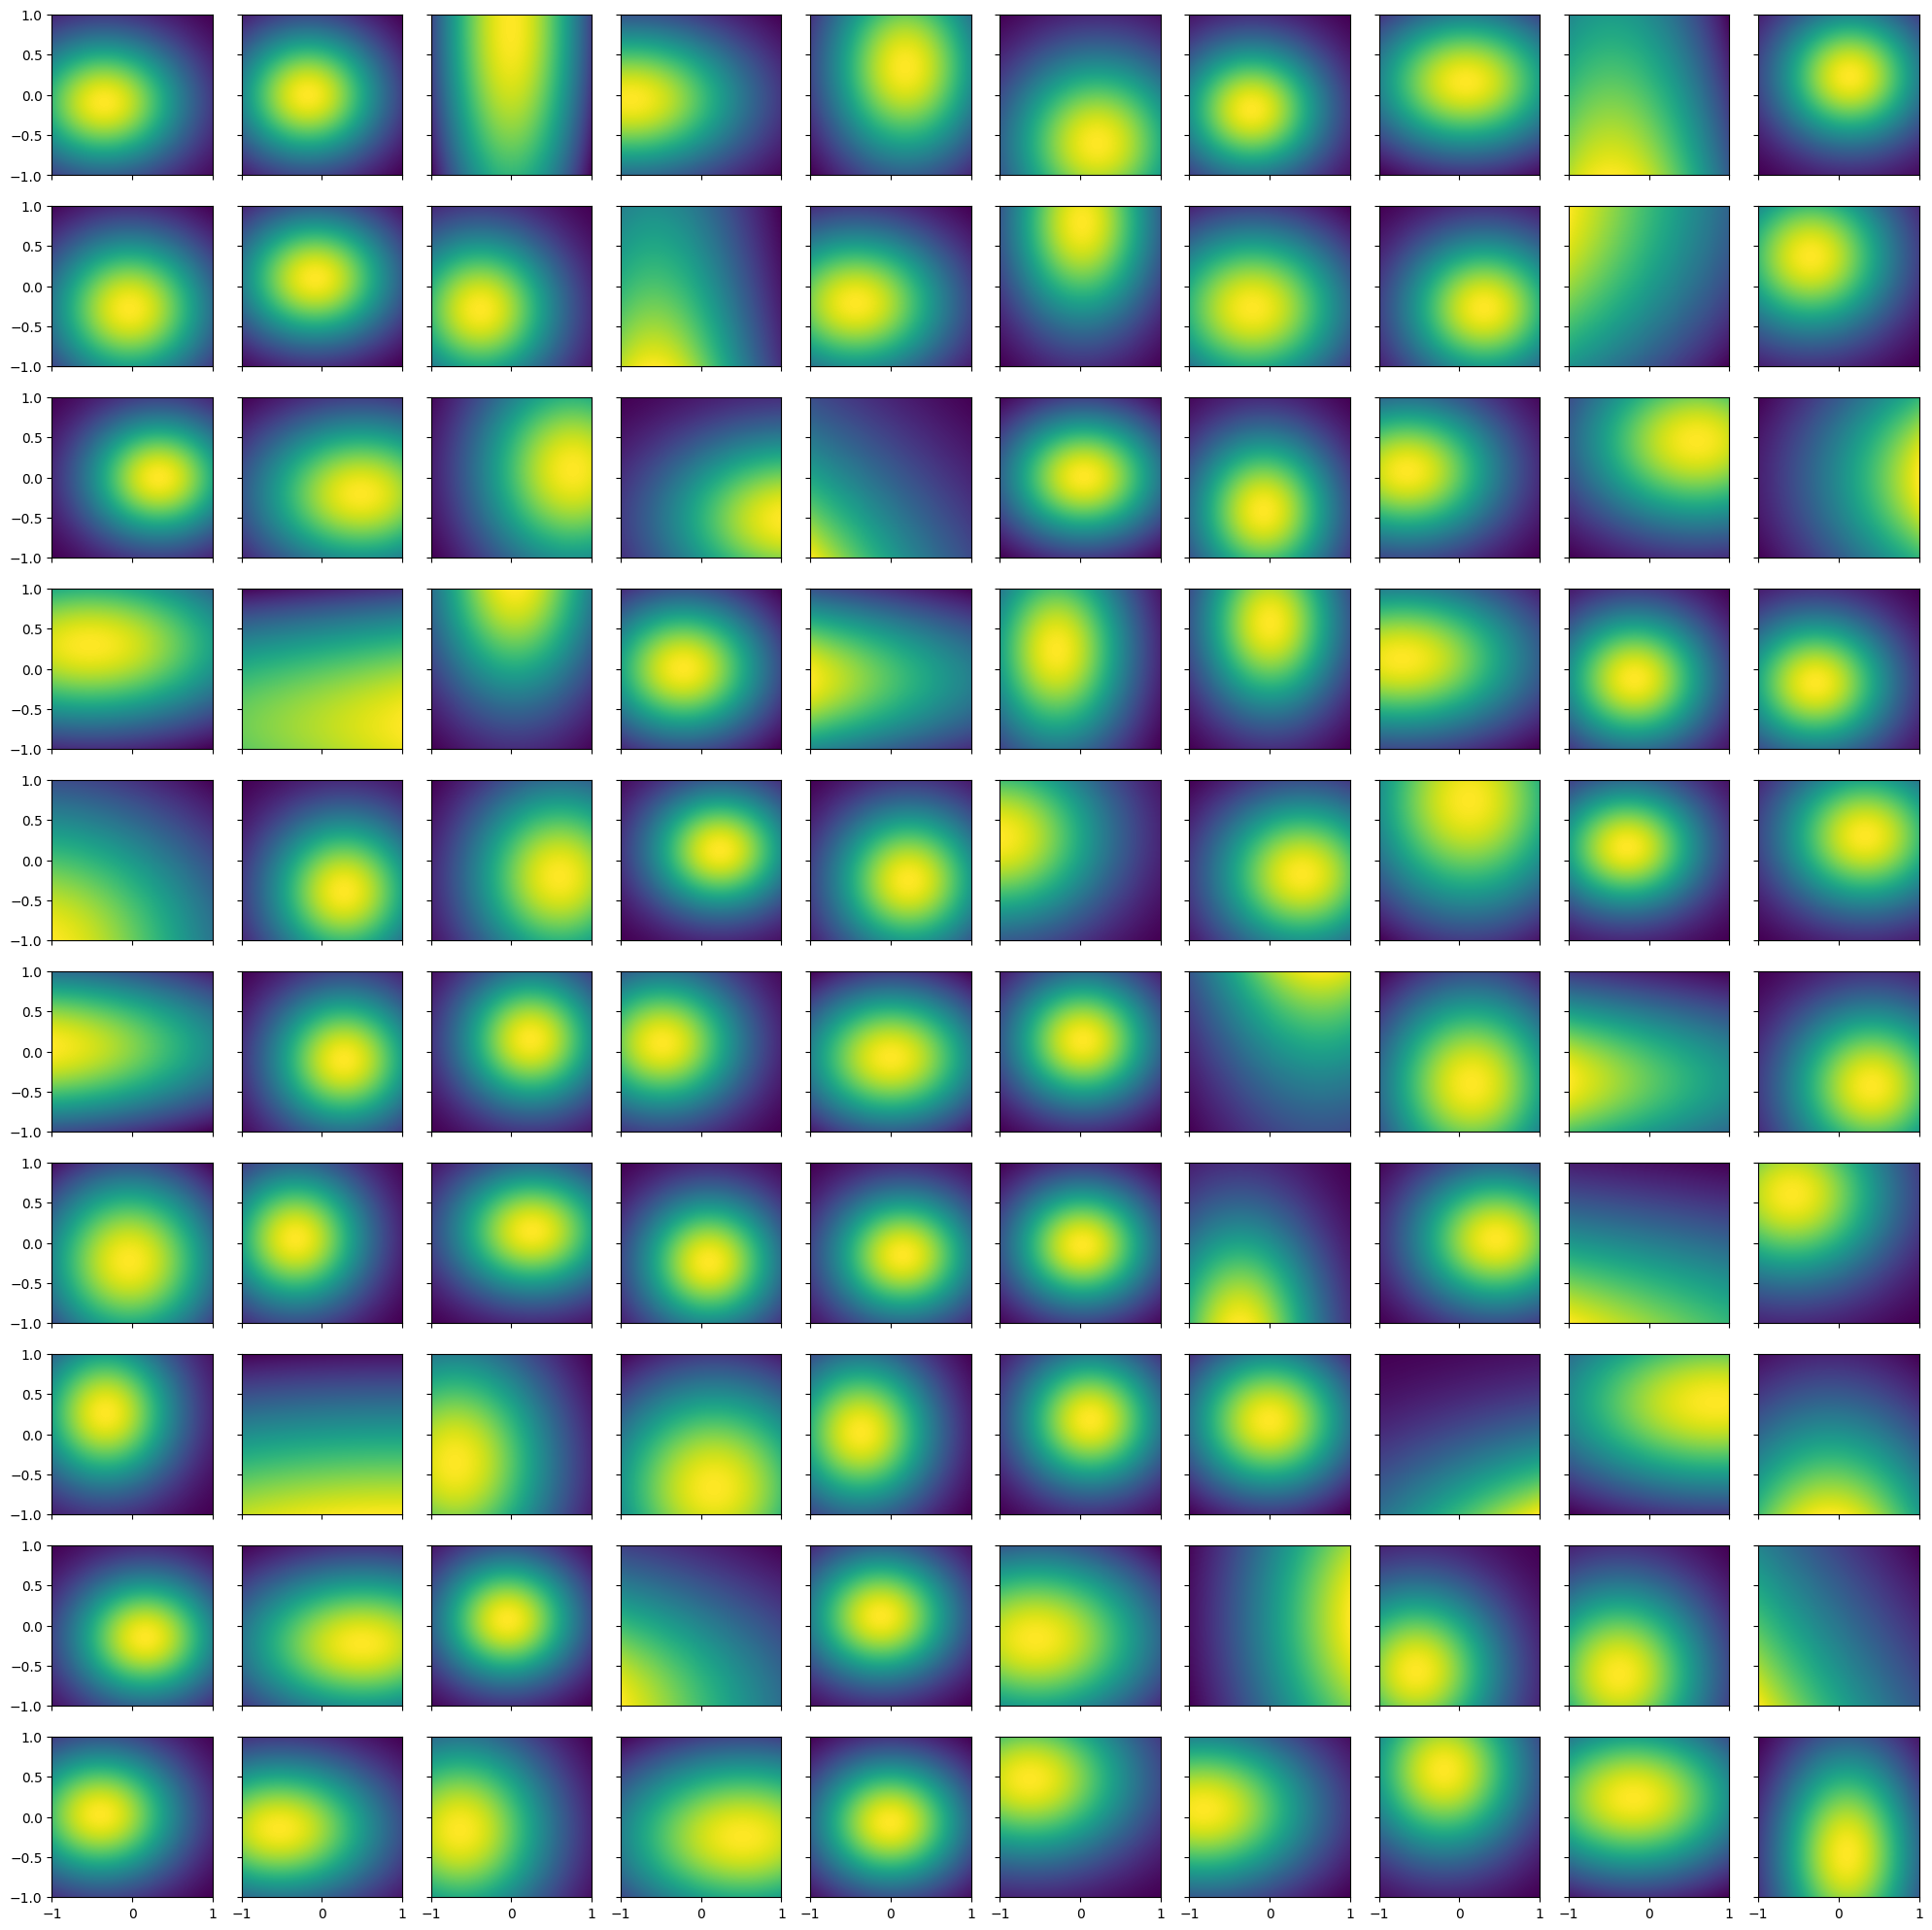

In [141]:
import numpy as np
import matplotlib.pyplot as plt

# Define the world size and resolution
world_size = (2, 2)
resolution = 200

# Define the range of resource sizes and shapes
min_size = 0.5
max_size = 2.0
min_shape = 0.5
max_shape = 2.0

# Define the number of resource gradients to generate
num_resources = 100

fig, axes = plt.subplots(10, 10, sharex=True, sharey=True, tight_layout=True, figsize=(20,20))

# Store all gradients.
all_gradients = np.zeros([num_resources, resolution**2])

# Generate the resource gradients
for i, ax in enumerate(axes.ravel()):
    
    # Randomly generate the resource size, shape, and position
    size = np.random.uniform(min_size, max_size)
    shape = np.random.uniform(min_shape, max_shape)
    pos_x = np.random.uniform(-1, 1)
    pos_y = np.random.uniform(-1, 1)
    
    # Calculate the bounds of the resource gradient based on the resource size and shape
    x_bound = world_size[0]/2 - size*2
    y_bound = world_size[1]/2 - size*2*shape
    
    # Generate the x and y coordinates of the ellipsoid gradient within the bounds and at the specified position
    x = np.linspace(-x_bound, x_bound, resolution) + pos_x
    y = np.linspace(-y_bound, y_bound, resolution) + pos_y
    xx, yy = np.meshgrid(x, y)
    
    # Calculate the distance of each point in the meshgrid from the center of the ellipsoid
    distance = np.sqrt((xx)**2 + ((yy)/shape)**2)
    
    # Calculate the gradient strength as a function of the distance from the center of the ellipsoid
    gradient = np.exp(-(distance**2)/(2*(size**2)))
    all_gradients[i] = gradient.ravel()
    
    # Plot the resource gradient
    ax.imshow(gradient, extent=[-1, 1, -1, 1])

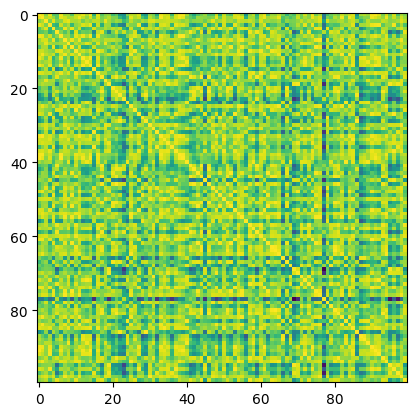

In [143]:
from sklearn.metrics.pairwise import cosine_similarity
test = cosine_similarity(all_gradients)
plt.imshow(test)